# Testing CasADi

Based on [this YouTube tutorial](https://www.youtube.com/watch?v=JI-AyLv68Xs).

In [1]:
from casadi import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.ticker import MaxNLocator

## System Definition

In [2]:
x = MX.sym('x', 2)
u = MX.sym('u')

ode = vertcat((1-x[1]**2)*x[0]-x[1]+u, x[0])

f = Function('f', [x, u], [ode], ['x', 'u'], ['dxdt'])
print(f)

print(f([0.2, 0.8], 0.1))

f:(x[2],u)->(dxdt[2]) MXFunction
[-0.628, 0.2]


### Integrator

In [3]:
T = 10
N = 20

intg_opts = {
  'simplify': True,
  'number_of_finite_elements': 4,
}

dae = {
  'x': x,
  'p': u, # constant over integration step
  'ode': f(x, u),
}

t0 = 0
tf = T/N
intg = integrator('intg', 'rk', dae, t0, tf, intg_opts)
print(intg)

res = intg(x0=[0,1], p=0)
print(res['xf'])

intg:(x0[2],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[2],zf[],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) MXFunction
[-0.494017, 0.876098]


In [4]:
res = intg(x0=x, p=u)
x_next = res['xf']
print(x_next)

F = Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])
print(F)

print(F([0, 1], 0))
print(F([0.1, 0.9], 0.1))

@1=0x0, intg(x, 0x1, u, 0x1, @1, @1, @1){0}
F:(x[2],u)->(x_next[2]) MXFunction
[-0.494017, 0.876098]
[-0.307745, 0.849043]


### Simulation

mapaccum_F:(x[2],u[1x20])->(x_next[2x20]) MXFunction


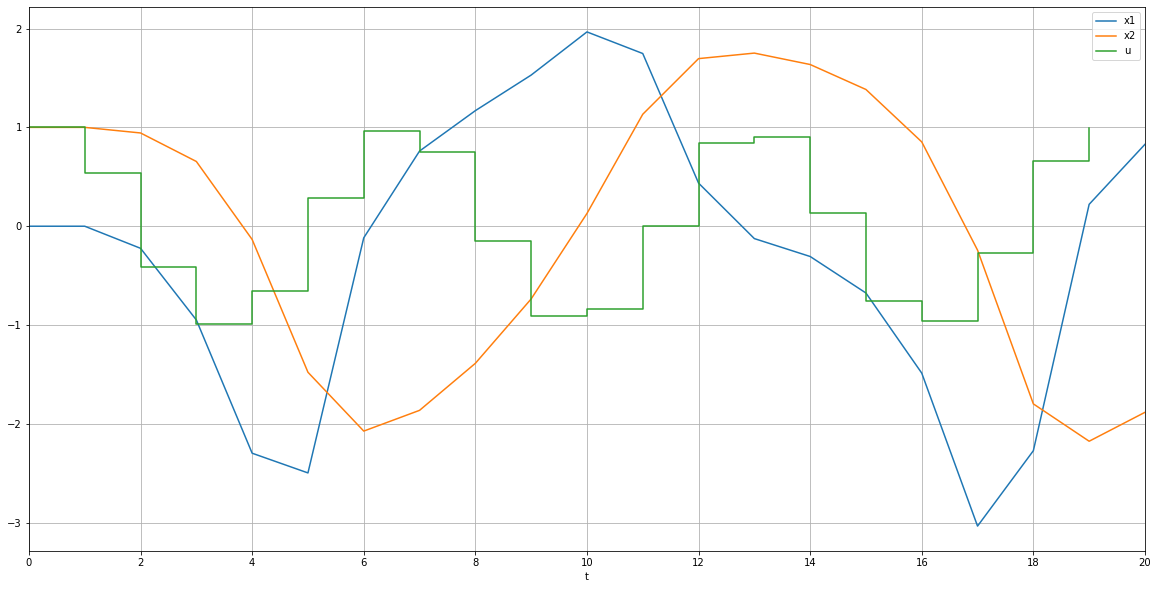

In [5]:
sim = F.mapaccum(N)
print(sim)

x0 = [0, 1]
u_grid = cos(range(N))
t_grid = range(N+1)

res = sim(x0, u_grid)
x_grid = horzcat(x0, res).T

plt.figure(figsize=(20,10))
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(t_grid, x_grid)
plt.plot(t_grid[0:-1], u_grid, drawstyle='steps-post')
plt.xlim(0, N)
plt.legend(['x1','x2','u'])
plt.xlabel('t')
plt.grid()
plt.show()

### Jacobian

In [6]:
U = MX.sym('U',1,N)

X = sim(x0,U)
print(X)

X1 = X[0,:]
print(X1)

J = jacobian(X1,U)
J.shape

mapaccum_F([0, 1], U){0}
mapaccum_F([0, 1], U){0}[:40:2]


(20, 20)

Jf:(U[1x20])->(J[20x20,210nz]) MXFunction


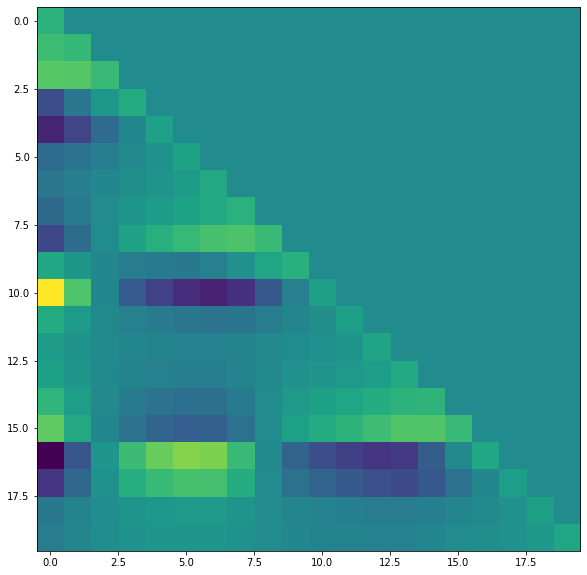

In [7]:
Jf = Function('Jf',[U],[J],['U'],['J'])
print(Jf)

plt.figure(figsize=(10,10))
plt.imshow(Jf(0))
plt.show()

## Optimization

Opti {
  instance #0
  #variables: 2 (nx = 62)
  #parameters: 1 (np = 2)
  #constraints: 22 (ng = 62)
  CasADi solver needs updating.
}
MESSAGE(sqpmethod): Convergence achieved after 4 iterations


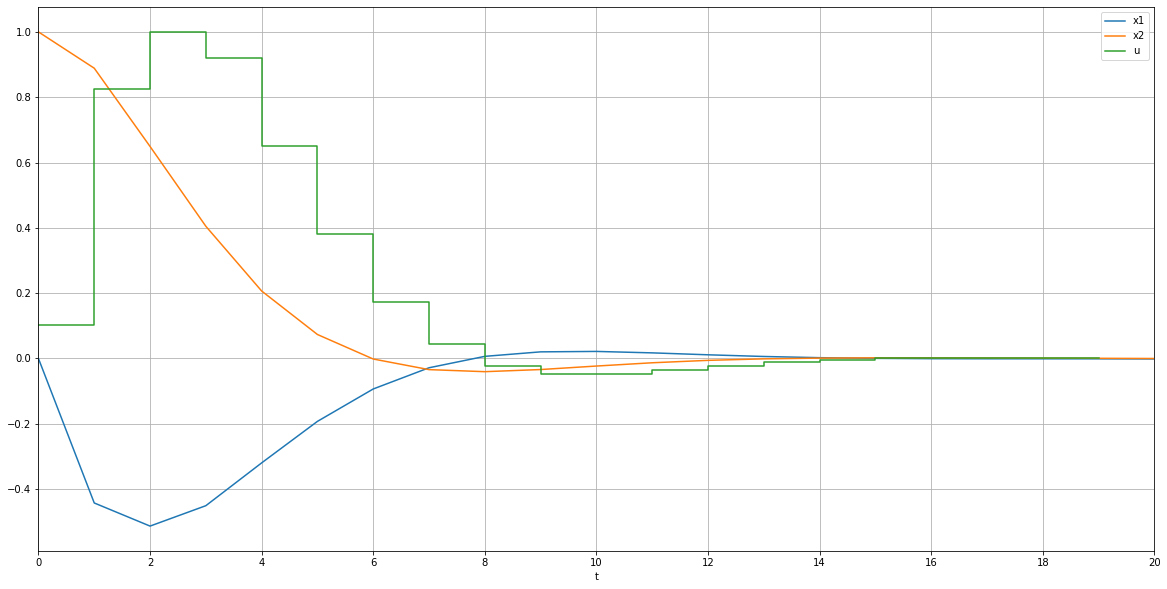

In [8]:
opti = Opti()

x = opti.variable(2, N + 1) # Decision variables for state trajectory
u = opti.variable(1, N)
p = opti.parameter(2, 1) # parameter not optimized over

u_min = -1
u_max = 1

opti.minimize(sumsqr(x) + sumsqr(u))

for k in range(N):
  opti.subject_to(x[:,k+1] == F(x[:,k], u[:,k]))
opti.subject_to(opti.bounded(u_min,u,u_max))
opti.subject_to(x[:,0] == p)

opti.solver('sqpmethod', {
  'qpsol':'qrqp',
  'print_header':False,
  'print_iteration':False,
  'print_time':False,
  'qpsol_options':{
    'print_header':False,
    'print_iter':False,
    'print_info':False,
  }
})
opti.set_value(p,[0,1])

print(opti)

sol = opti.solve()

plt.figure(figsize=(20,10))
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(t_grid, sol.value(x).T)
plt.plot(t_grid[0:-1], sol.value(u), drawstyle='steps-post')
plt.xlim(0, N)
plt.legend(['x1','x2','u'])
plt.xlabel('t')
plt.grid()
plt.show()

In [9]:
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])
print(M)

M:(p[2])->(u_opt) MXFunction


### MPC

MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 4 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 3 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved after 2 iterations
MESSAGE(sqpmethod): Convergence achieved

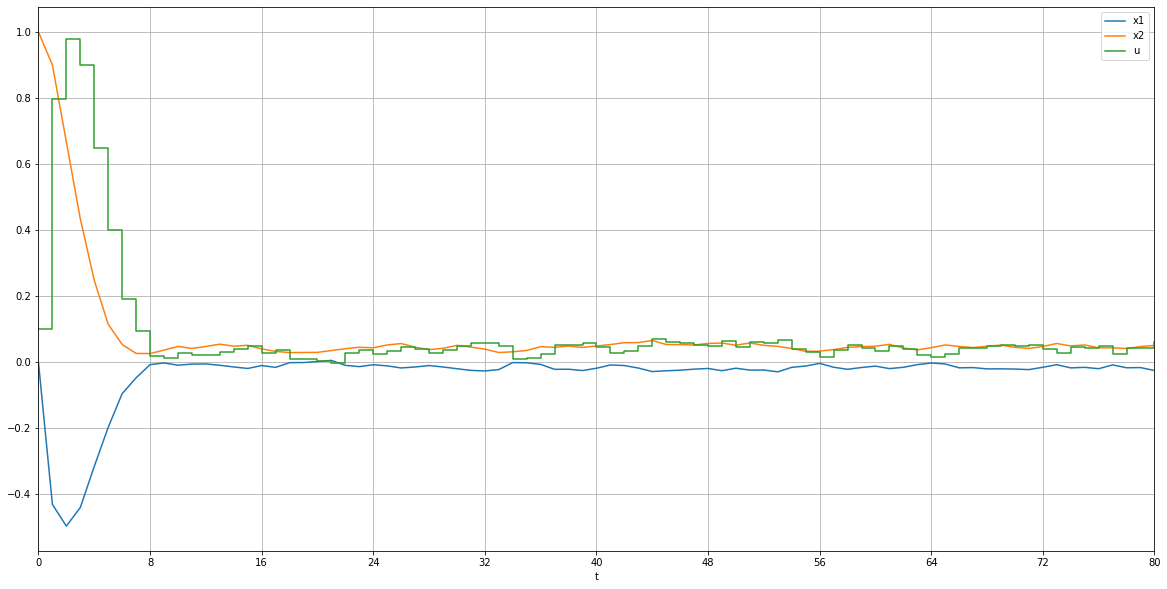

In [10]:
x = [0,1]

NN = 4*N+1

t_log = range(NN)
x_log = np.empty((0,2))
u_log = np.empty((0,1))
for i in range(NN):
  u = np.array(M(x))[:,0]

  x_log = np.vstack((x_log, x))
  u_log = np.vstack((u_log, u))

  x = np.array(F(x,u))[:,0] + 0.02*np.random.rand(1,2)

plt.figure(figsize=(20,10))
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(t_log, x_log)
plt.plot(t_log, u_log, drawstyle='steps-post')
plt.xlim(0, NN - 1)
plt.legend(['x1','x2','u'])
plt.xlabel('t')
plt.grid()
plt.show()